<a href="https://colab.research.google.com/github/linglinghsieh00/LP/blob/main/Untitled4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the package
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import math
import matplotlib as mpl
from scipy.stats import poisson
from scipy.stats import nbinom
import scipy.stats as stats
from scipy.stats import expon
from scipy.optimize import curve_fit
import datetime
from math import sqrt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/uni/data"

/content/drive/MyDrive/uni/data


In [ ]:
data2_trade = pd.read_csv("data2_trade.csv")
data1_trade = pd.read_csv("data1_trade.csv")
data2_liquidity = pd.read_csv("data2_liquidity.csv")

<ipython-input-14-e887bd8f2731>:2: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data1_trade = pd.read_csv("data1_trade.csv")
<ipython-input-14-e887bd8f2731>:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data2_liquidity = pd.read_csv("data2_liquidity.csv")


In [ ]:
data1_trade.head()

timestamp  blockNumber event             amount0   amount1  \
0  1630419316       227484  Swap   10000000000000000 -18001595   
1  1630447626       228417  Swap  -10000000000000000  18020728   
2  1630453183       228739  Swap   -4937446423517171  10000000   
3  1630453308       228740  Swap  -24680402357841083  50000000   
4  1630453472       228753  Swap  -36068826010049611  75000000   

          liquidity               sqrtPriceX96    tick  
0     3632971980651  3171790482976860351510409 -202526  
1     3632971980651  3564591523519471518150042 -200191  
2  4816711909698018  3564755927266088724290248 -200190  
3  4816711909698018  3565577945999174754991281 -200186  
4      919807797226  4705102282435095156608027 -194639

In [ ]:
data2_trade.head()

Unnamed: 0   timestamp  blockNumber  amount_0   amount_1    tick  \
0           0  1630419316       227484  0.010000 -18.001595 -202526   
1           1  1630447626       228417 -0.010000  18.020728 -200191   
2           2  1630453183       228739 -0.004937  10.000000 -200190   
3           3  1630453308       228740 -0.024680  50.000000 -200186   
4           4  1630453472       228753 -0.036069  75.000000 -194639   

         price                 time  
0  1602.691065  2021-08-31 22:15:16  
1  2024.232403  2021-09-01 06:07:06  
2  2024.419128  2021-09-01 07:39:43  
3  2025.352882  2021-09-01 07:41:48  
4  3526.784880  2021-09-01 07:44:32

In [ ]:
data2_liquidity.head()

Unnamed: 0     timestamp  blockNumber event  amount_0     amount_1  \
0           0  1.630409e+09     227288.0  Mint  0.001000     0.000000   
1           1  1.630453e+09     228713.0  Mint  0.057544   100.000000   
2           2  1.630456e+09     228962.0  Mint  0.001301     3.371855   
3           3  1.630459e+09     229112.0  Mint  0.285168  1346.888839   
4           4  1.630459e+09     229166.0  Mint  0.010000     0.000000   

          liquidity  tickLower  tickUpper  lower_price  upper_price  \
0      919807797226  -194710.0  -193380.0  3501.667635  3999.753253   
1  4813078937717367  -200200.0  -200180.0  2022.363284  2026.411856   
2      229961494372  -200310.0  -186450.0  2000.240294  7998.052102   
3   273489084741947  -196370.0  -193360.0  2966.099000  4007.760364   
4     3720326698897  -194630.0  -191150.0  3529.791917  4998.918171   

                  time  
0  2021-08-31 19:19:24  
1  2021-09-01 07:34:56  
2  2021-09-01 08:20:48  
3  2021-09-01 09:11:38  
4  2021-09-01 09:21:29

In [ ]:
data1_trade['liquidity'] = data1_trade['liquidity'].astype(float)
data2_trade['liquidity'] = data1_trade['liquidity']
data2_trade['n_amount_1'] = data2_trade['amount_1'] / data2_trade['liquidity']
data2_trade['n_amount_0'] = data2_trade['amount_0'] / data2_trade['liquidity']

In [ ]:
data1_trade['amount0'] = data1_trade['amount0'].astype(float)
data1_trade['amount1'] = data1_trade['amount1'].astype(float)

In [ ]:
data2_liquidity['liquidity'] = data2_liquidity['liquidity'].astype(float)
data2_liquidity['n_amount_0'] =  data2_liquidity['amount_0']/data2_liquidity['liquidity']
data2_liquidity['n_amount_1'] =  data2_liquidity['amount_1']/data2_liquidity['liquidity']

## Analyze price volume:

Setting: token0: WETH, token1: USDC

amount0 > 0 : bid

amount0 < 0 : ask

### Interday activity

In [ ]:
# inpute
# target_date: start day
# data
# daytime: how many day you want to observe
def time_d(target_date, data, daytime):
    start_day = pd.to_datetime(target_date)
    end_day = start_day + pd.Timedelta(days=daytime)
    data_d = data[(data.index >= start_day) & (data.index < end_day)]
    return data_d

In [ ]:
bid = pd.DataFrame()
ask = pd.DataFrame()
bid = data2_trade[data2_trade['amount_0'] < 0]
ask = data2_trade[data2_trade['amount_0'] > 0]
bid['time'] = pd.to_datetime(bid['time'])
ask['time'] = pd.to_datetime(ask['time'])
bid.set_index(['time'], inplace = True)
ask.set_index(['time'], inplace = True)

<ipython-input-10-b2656a443910>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bid['time'] = pd.to_datetime(bid['time'])
<ipython-input-10-b2656a443910>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ask['time'] = pd.to_datetime(ask['time'])


[]

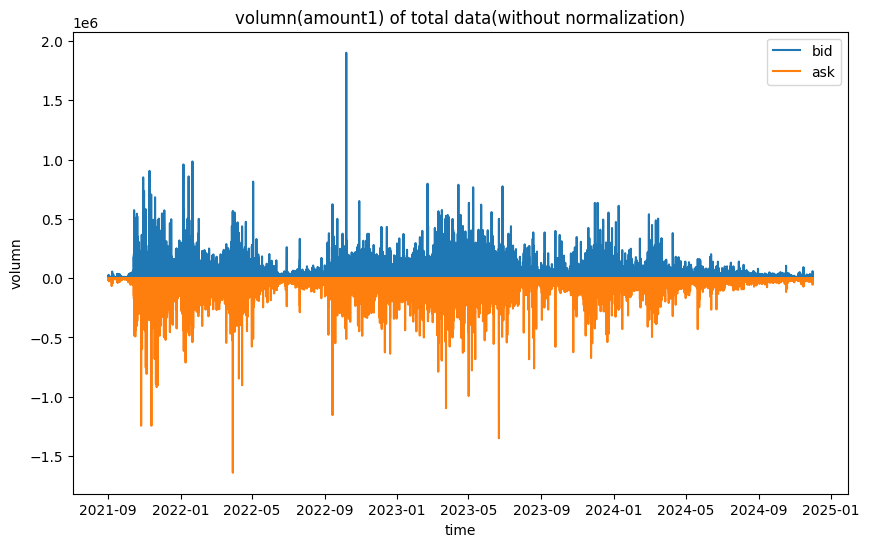

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(bid['amount_1'], label = 'bid')
plt.plot(ask['amount_1'], label = 'ask')
plt.legend()
plt.title('volumn(amount1) of total data(without normalization)')
plt.xlabel('time')
plt.ylabel('volumn')
plt.plot()

### Interday activity

1. Early Hours (0-600 minutes, approximately midnight to 10:00 AM):
Declining Volume: Trading volume starts relatively high at the beginning of the day but steadily decreases throughout this period.

2. Midday (600-1200 minutes, approximately 10:00 AM to 6:00 PM):
Low and Stable Volume: This period represents the trough of the trading activity. The median volume remains low and relatively stable.

3. Late Evening Surge (1200-1440 minutes, approximately 6:00 PM to midnight):
Rapidly Increasing Volume: The most prominent feature of the chart is the sharp increase in trading volume towards the end of the day.

In [ ]:
bid_2023 = time_d('2023-01-01', bid, 365)
ask_2023 = time_d('2023-01-01', ask, 365)

In [ ]:
# Group the data in 5 min
bid_2023_5m = bid_2023.resample('5min').sum()
ask_2023_5m = ask_2023.resample('5min').sum()

In [ ]:
bid_5m_vol = bid_2023_5m['n_amount_1']
ask_5m_vol = ask_2023_5m['n_amount_1']

In [ ]:
def grouptime(df):
  df_all = pd.DataFrame()
  for (hour, minute), series in df:
    time_str = f"{hour:02d}:{minute:02d}"
    df_temp = pd.DataFrame({'time': time_str, 'volume': np.log(series.values+1)})
    df_all = pd.concat([df_all, df_temp])

  df_all['time_minutes'] = df_all['time'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
  df_all_t = df_all.drop('time', axis=1)
  df_all_t.set_index(['time_minutes'], inplace = True)
  df_all_q = df_all_t.groupby([df_all_t.index]).describe()
  return df_all_t, df_all_q

In [ ]:
bid_5m_vol = bid_5m_vol.groupby([bid_5m_vol.index.hour, bid_5m_vol.index.minute])
ask_5m_vol = ask_5m_vol.groupby([ask_5m_vol.index.hour, ask_5m_vol.index.minute])

In [ ]:
df_all_bid, df_all_bid_q = grouptime(bid_5m_vol)
df_all_ask, df_all_ask_q = grouptime(ask_5m_vol)

Text(0.5, 1.0, 'Ask volume(normalize) as function of time a day(2023)')

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


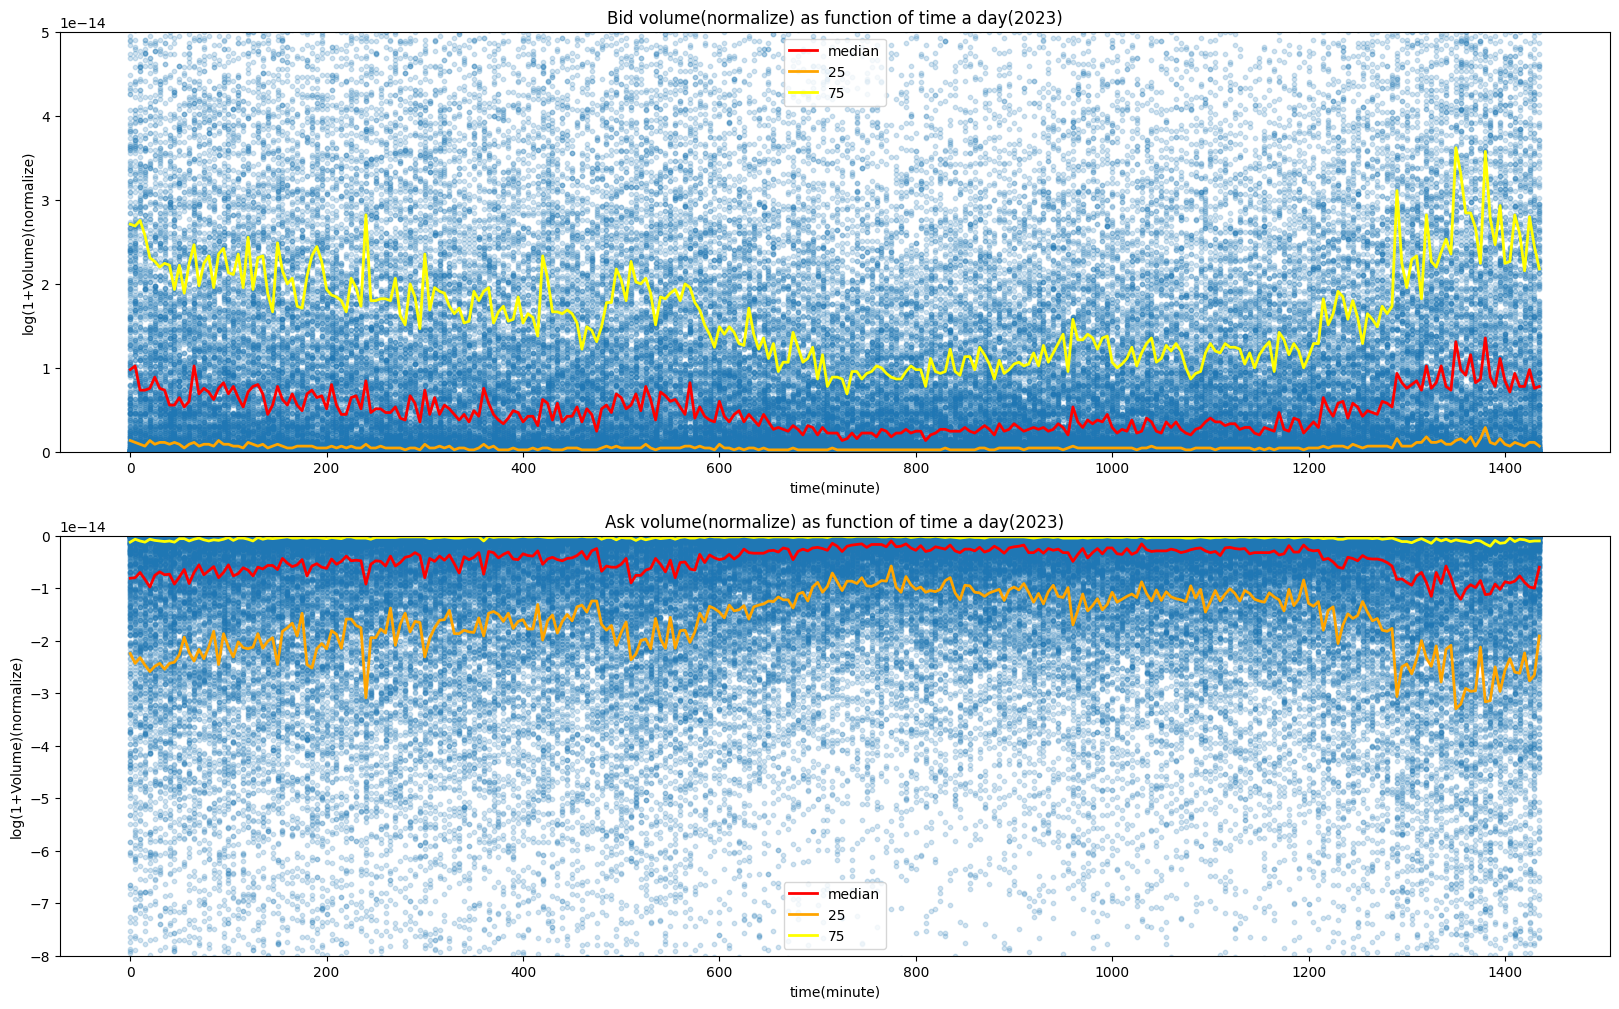

In [ ]:
plt.figure(figsize=(20, 12))

plt.subplot(211)
plt.scatter(df_all_bid.index,df_all_bid['volume'], s=10, alpha=0.2, c='tab:blue')

plt.plot(df_all_bid_q['volume']['50%'],label='median', color = 'red', linewidth = 2)
plt.plot(df_all_bid_q['volume']['25%'],label='25', color = 'orange', linewidth = 2)
plt.plot(df_all_bid_q['volume']['75%'],label='75', color = 'yellow', linewidth = 2)

plt.ylim(top = 5e-14, bottom=0)
#plt.ylim(top = 0.5)
plt.legend()
plt.ylabel('log(1+Volume)(normalize)')
plt.xlabel('time(minute)')
plt.title('Bid volume(normalize) as function of time a day(2023)')

# -----------------------------

plt.subplot(212)
plt.scatter(df_all_ask.index,df_all_ask['volume'], s=10, alpha=0.2, c='tab:blue')

plt.plot(df_all_ask_q['volume']['50%'],label='median', color = 'red', linewidth = 2)
plt.plot(df_all_ask_q['volume']['25%'],label='25', color = 'orange', linewidth = 2)
plt.plot(df_all_ask_q['volume']['75%'],label='75', color = 'yellow', linewidth = 2)

plt.ylim(top = 0, bottom= -8e-14)
plt.legend()
plt.ylabel('log(1+Volume)(normalize)')
plt.xlabel('time(minute)')
plt.title('Ask volume(normalize) as function of time a day(2023)')

## Non-Markovian Nature of price change

### single price change

In [ ]:
def transition_counts(df):
    df['price_change'] = df['tick'].diff()
    df['state'] = df['price_change'].apply(lambda x: 'Uptick (↑)' if x > 0 else ('Downtick (↓)' if x < 0 else 'No Change'))
    df = df[~df["state"].isin(['No Change'])]
    df['prev_state'] = df['state'].shift(1)
    transition = df.groupby(['prev_state', 'state']).size().unstack(fill_value=0)
    transition_rates = transition.div(transition.sum(axis=1), axis=0) * 100
    return transition_rates


In [ ]:
transition_counts_bid = transition_counts(bid)
transition_counts_ask = transition_counts(ask)

<ipython-input-15-cc618a3d6479>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_change'] = df['tick'].diff()
<ipython-input-15-cc618a3d6479>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state'] = df['price_change'].apply(lambda x: 'Uptick (↑)' if x > 0 else ('Downtick (↓)' if x < 0 else 'No Change'))
<ipython-input-15-cc618a3d6479>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [ ]:
# bid
print("bid")
transition_counts_bid

bid


state         Downtick (↓)  Uptick (↑)
prev_state                            
Downtick (↓)     39.850276   60.149724
Uptick (↑)       33.731467   66.268533

In [ ]:
# ask
print("ask")
transition_counts_ask

ask


state         Downtick (↓)  Uptick (↑)
prev_state                            
Downtick (↓)     66.068278   33.931722
Uptick (↑)       60.603310   39.396690

### Pairs of tick changes

In [ ]:
def transition_counts_pairs(df):
    df['price_change'] = df['tick'].diff()
    df = df.dropna()
    labels = ['Down', 'No Change', 'Up']
    bins = [-float('inf'), -1e-8, 1e-8, float('inf')]
    df['Direction'] = pd.cut(df['price_change'], bins=bins, labels=labels)
    df['Next Prices'] = df['Direction'].shift(-1).astype(str) + ' ' + df['Direction'].shift(-2).astype(str)
    df = df[:-2]

    remove_list = ["Up No Change", "No Change No Change", "No Change Up", "No Change Down","Down No Change"]
    df = df[~df["Next Prices"].isin(remove_list)]
    df["Next Prices"] = df["Next Prices"].replace({"Down Up": "Reversal", "Up Down": "Reversal"})
    pivot_table = pd.pivot_table(df, index='Direction', columns='Next Prices', aggfunc='size', fill_value=0)

    pivot_table.loc['Up'] = pivot_table.loc['Up'] / pivot_table.loc['Up'].sum()
    pivot_table.loc['Down'] = pivot_table.loc['Down'] / pivot_table.loc['Down'].sum()
    pivot_table.loc['No Change'] = pivot_table.loc['No Change'] / pivot_table.loc['No Change'].sum()

    return pivot_table*100

In [ ]:
transition_counts_pairs_bid = transition_counts_pairs(bid)

<ipython-input-19-be773a93ce53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_change'] = df['tick'].diff()
<ipython-input-19-be773a93ce53>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Direction'] = pd.cut(df['price_change'], bins=bins, labels=labels)
<ipython-input-19-be773a93ce53>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [ ]:
transition_counts_pairs_ask = transition_counts_pairs(ask)

<ipython-input-19-be773a93ce53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_change'] = df['tick'].diff()
<ipython-input-19-be773a93ce53>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Direction'] = pd.cut(df['price_change'], bins=bins, labels=labels)
<ipython-input-19-be773a93ce53>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [ ]:
# Bid
print("bid")
transition_counts_pairs_bid

bid


Next Prices  Down Down   Reversal      Up Up
Direction                                   
Down         16.336532  46.857087  36.806381
No Change    15.032955  40.893017  44.074027
Up           13.683152  52.282297  34.034551

In [ ]:
# Bid
print("ask")
transition_counts_pairs_ask

ask


Next Prices  Down Down   Reversal      Up Up
Direction                                   
Down         33.609790  52.736542  13.653668
No Change    44.268345  41.194029  14.537625
Up           36.949554  47.109251  15.941195

# Interarrival time

We fit distributions using MLE.
1. powerlaw
2. gamma
3. pareto
4. weibull_min
5. normal distribution



In [ ]:
df_inter = data2_trade
df_inter['time'] = pd.to_datetime(df_inter['time'])

In [ ]:
df_inter['interarrival_times_num'] = df_inter['blockNumber'].diff()
df_inter = df_inter.dropna()
df_inter=df_inter[df_inter['interarrival_times_num'] > 0]

In [ ]:
df_inter.set_index(['time'], inplace = True)

In [ ]:
df_inter_1d = time_d('2024-06-15', df_inter, 1)

In [ ]:
num = df_inter_1d['interarrival_times_num'].value_counts()
num = num.sort_index()
count = num.sum()
density = num/count
mu = num.mean()
n = len(df_inter_1d['interarrival_times_num'])
Var = num.var()
p =  (mu/Var)
r = mu**2 / (Var-mu)
x = num.index

In [ ]:
# powerlaw
fit = stats.powerlaw.fit(density,loc=x.min(), scale=x.max())

# gamma
gfit = stats.gamma.fit(density,loc=x.min(), scale=x.max())

# pareto
pfit = stats.pareto.fit(density,loc=x.min(), scale=x.max())

# weibull_min
w = stats.weibull_min.fit(density,loc=x.min(), scale=x.max())

In [ ]:
s = np.median(x)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:2509: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


[]

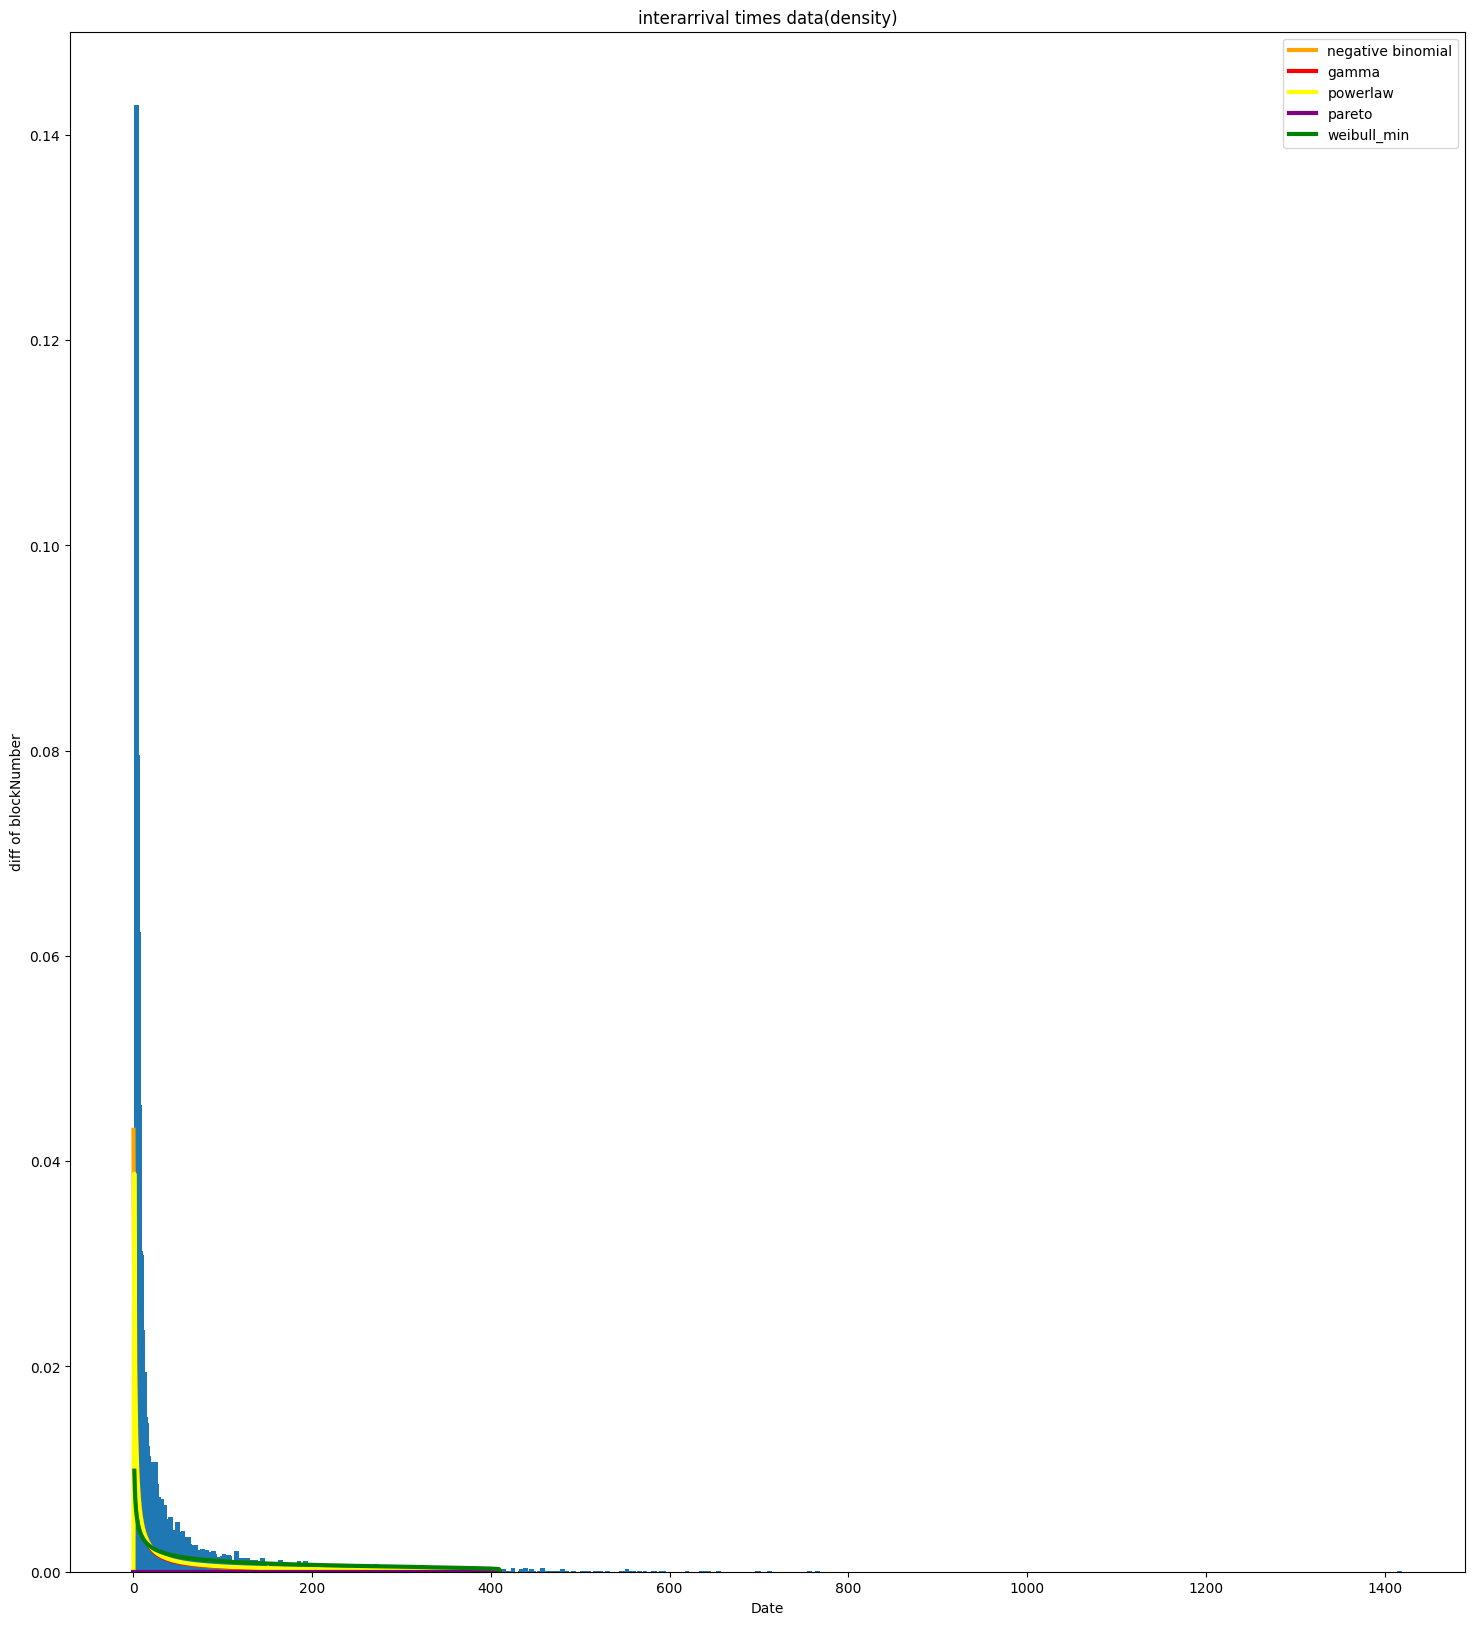

In [ ]:
plt.figure(figsize=(18, 20))
plt.bar(density.index, density, width = 5, align='edge')

plt.plot(nbinom.pmf(x,r,p), color='orange', label = 'negative binomial',linewidth=3.0)

plt.plot(stats.gamma.pdf(x, gfit[0], loc=x.min(), scale=x.max()), 'r-', label='gamma',linewidth=3.0)
plt.plot(stats.powerlaw.pdf(x, fit[0], loc=x.min(), scale=x.max()), 'yellow', label='powerlaw',linewidth=3.0)
plt.plot(stats.pareto.pdf(x, pfit[0], loc=x.min(), scale=x.max()), 'purple', label='pareto',linewidth=3.0)
plt.plot(stats.weibull_min.pdf(x, w[0], loc=x.min(), scale=x.max()), 'green', label='weibull_min',linewidth=3.0)

plt.legend()
plt.title('interarrival times data(density)')
plt.xlabel('Date')
plt.ylabel('diff of blockNumber')
plt.plot()

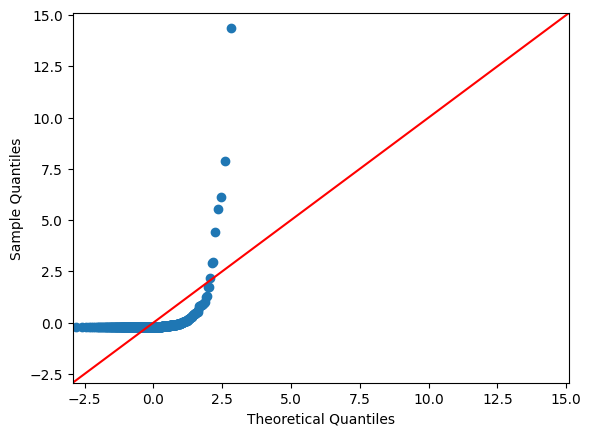

In [ ]:
# normal distribution
fig = sm.qqplot(density,fit=True, line="45")

((array([ 9., 10., 10., 11., 11., 11., 12., 12., 12., 12., 12., 13., 13.,
         13., 13., 13., 13., 13., 13., 13., 14., 14., 14., 14., 14., 14.,
         14., 14., 14., 14., 14., 14., 14., 15., 15., 15., 15., 15., 15.,
         15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 16.,
         16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
         16., 16., 16., 16., 16., 16., 16., 16., 17., 17., 17., 17., 17.,
         17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
         17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 18., 18., 18.,
         18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18.,
         18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18.,
         18., 18., 18., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19.,
         19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19.,
         19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 20.,
         20., 20., 20., 20., 20., 20.,

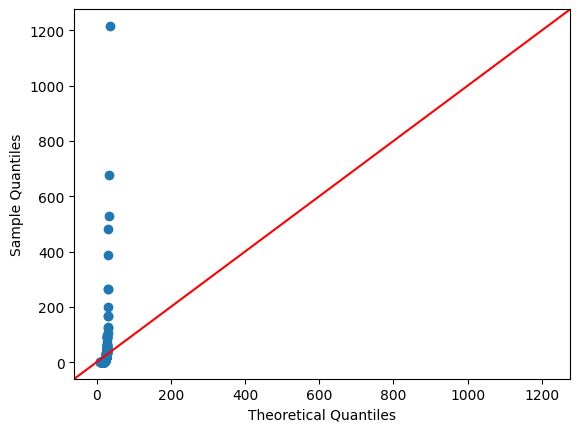

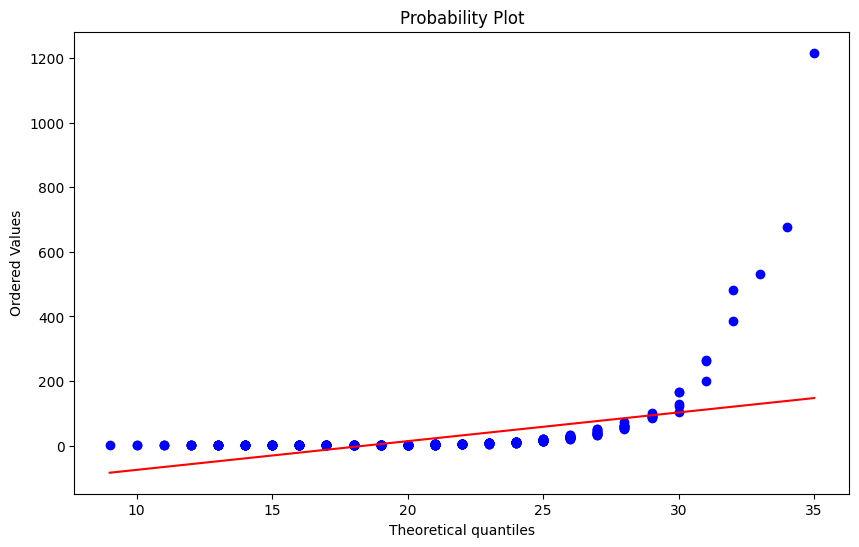

In [ ]:
# poisson
pdist = stats.poisson(mu)
sm.qqplot(num, dist=pdist,line="45")
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(num, dist=pdist, plot=ax)

((array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.

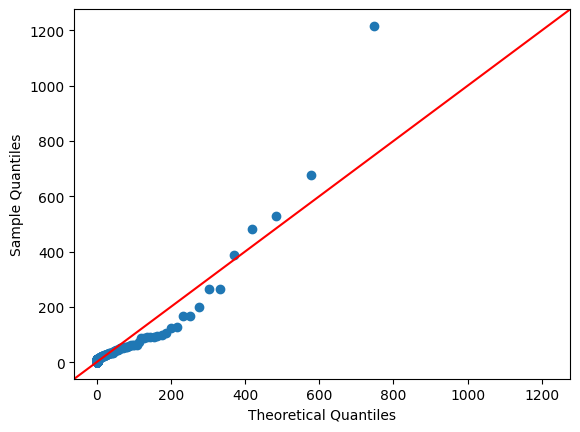

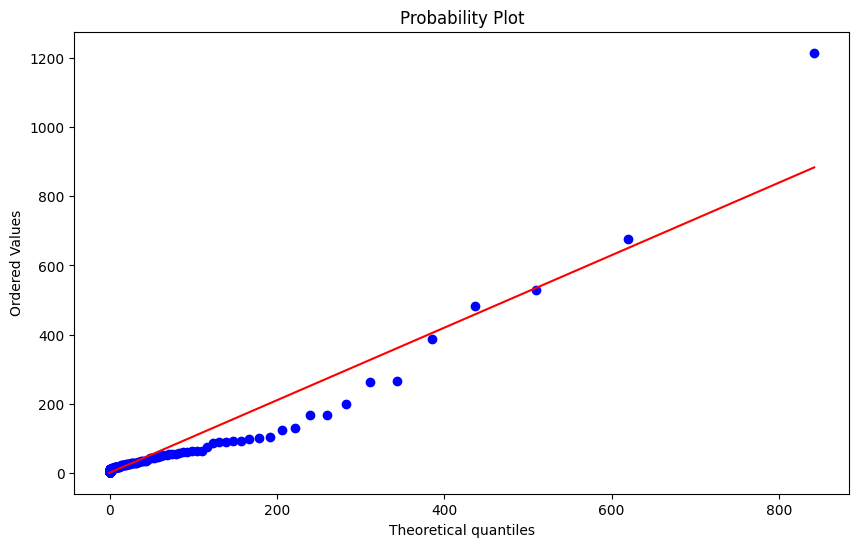

In [ ]:
# negative binominal
qdist = nbinom(r,p)
sm.qqplot(num, dist=qdist, line="45")
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(num, dist=qdist, plot=ax)

((array([4.74912144e-47, 1.28543884e-40, 3.11022751e-37, 6.18236391e-35,
         3.41858765e-33, 8.66793847e-32, 1.29953611e-30, 1.33466718e-29,
         1.03038482e-28, 6.36440199e-28, 3.28643676e-27, 1.46502891e-26,
         5.77592355e-26, 2.05190425e-25, 6.66563253e-25, 2.00354062e-24,
         5.62600470e-24, 1.48761449e-23, 3.72858077e-23, 8.90807868e-23,
         2.03833541e-22, 4.48528071e-22, 9.52483636e-22, 1.95799936e-21,
         3.90681112e-21, 7.58430276e-21, 1.43549903e-20, 2.65395901e-20,
         4.80079750e-20, 8.50961271e-20, 1.48002219e-19, 2.52881580e-19,
         4.24948140e-19, 7.03008088e-19, 1.14600889e-18, 1.84239451e-18,
         2.92332972e-18, 4.58120917e-18, 7.09532213e-18, 1.08671254e-17,
         1.64683171e-17, 2.47058360e-17, 3.67090870e-17, 5.40461495e-17,
         7.88775467e-17, 1.14158389e-16, 1.63902460e-16, 2.33525177e-16,
         3.30286453e-16, 4.63859449e-16, 6.47057199e-16, 8.96756280e-16,
         1.23506534e-15, 1.69079655e-15, 2.30131031

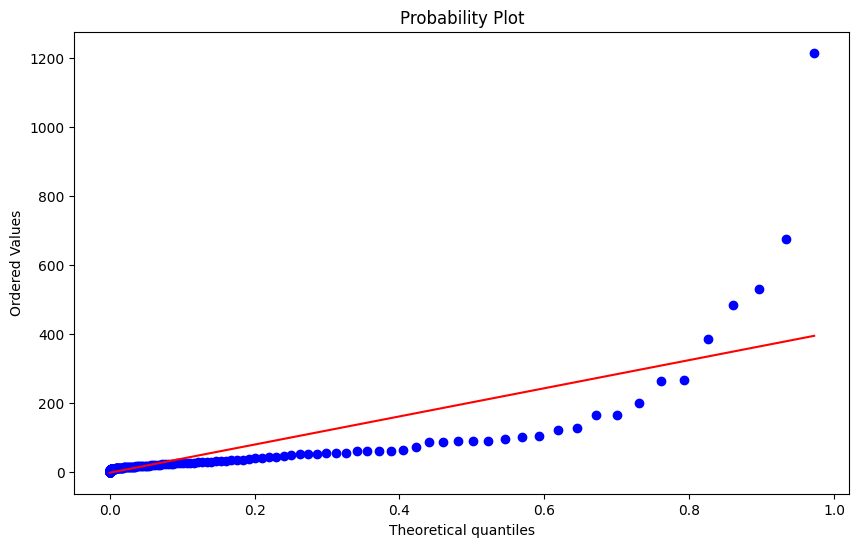

In [ ]:
# powerlaw
pow = stats.powerlaw.fit(num)
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(num, dist=stats.powerlaw, sparams=(pow[0], ), plot=ax)

((array([1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1

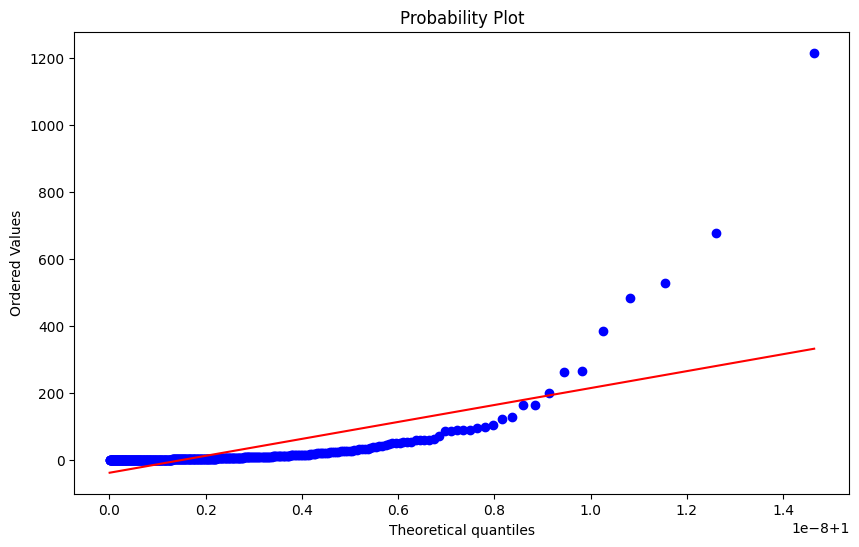

In [ ]:
# pareto
p = stats.pareto.fit(num)
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(num, dist=stats.pareto, sparams=(p[0], ), plot=ax)

((array([3.60016958e-189, 4.89121744e-163, 2.73246738e-149, 5.94458835e-140,
         7.14767292e-133, 3.61811382e-127, 2.16623016e-122, 2.78916243e-118,
         1.12625747e-114, 1.83761365e-111, 1.44820835e-108, 6.28083474e-106,
         1.65377338e-103, 2.85193459e-101, 3.41949100e-099, 2.99060145e-097,
         1.98373210e-095, 1.03067958e-093, 4.30882283e-092, 1.48264744e-090,
         4.28100732e-089, 1.05457868e-087, 2.24832518e-086, 4.20051788e-085,
         6.95271168e-084, 1.02941830e-082, 1.37504024e-081, 1.66961321e-080,
         1.85538424e-079, 1.89848668e-078, 1.79850971e-077, 1.58524632e-076,
         1.30588945e-075, 1.00951472e-074, 7.35073723e-074, 5.05869820e-073,
         3.30058832e-072, 2.04754940e-071, 1.21092065e-070, 6.84376629e-070,
         3.70470488e-069, 1.92486528e-068, 9.61789345e-068, 4.62997268e-067,
         2.15094003e-066, 9.65858489e-066, 4.19830036e-065, 1.76891569e-064,
         7.23395681e-064, 2.87479649e-063, 1.11146672e-062, 4.18514652e-062,

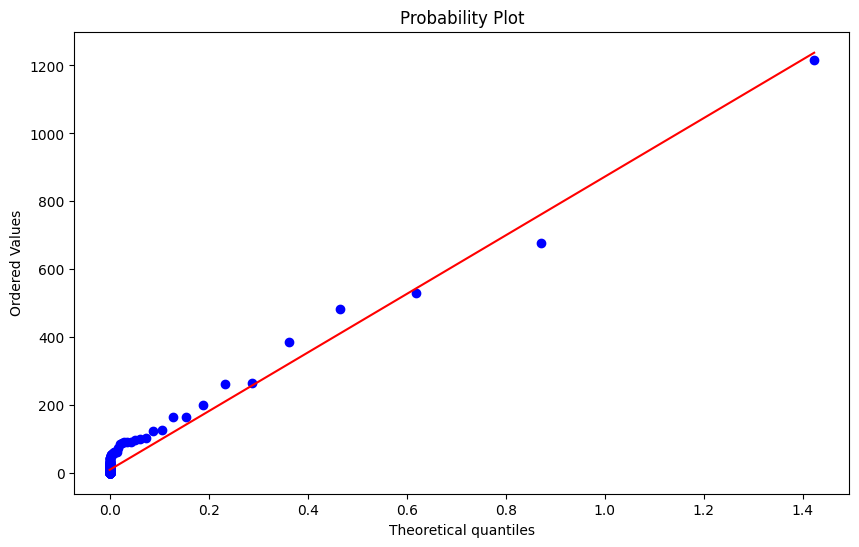

In [ ]:
# gamma
g = stats.gamma.fit(num)
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(num, dist=stats.gamma, sparams=(g[0], ), plot=ax)

((array([3.33673300e-05, 1.39919290e-04, 2.97701109e-04, 4.97485656e-04,
         7.34641617e-04, 1.00610545e-03, 1.30965673e-03, 1.64359347e-03,
         2.00656050e-03, 2.39744880e-03, 2.81533180e-03, 3.25942274e-03,
         3.72904501e-03, 4.22361057e-03, 4.74260400e-03, 5.28557033e-03,
         5.85210557e-03, 6.44184920e-03, 7.05447821e-03, 7.68970218e-03,
         8.34725926e-03, 9.02691288e-03, 9.72844885e-03, 1.04516731e-02,
         1.11964095e-02, 1.19624983e-02, 1.27497945e-02, 1.35581666e-02,
         1.43874954e-02, 1.52376733e-02, 1.61086026e-02, 1.70001959e-02,
         1.79123744e-02, 1.88450678e-02, 1.97982135e-02, 2.07717564e-02,
         2.17656479e-02, 2.27798463e-02, 2.38143157e-02, 2.48690260e-02,
         2.59439525e-02, 2.70390757e-02, 2.81543811e-02, 2.92898589e-02,
         3.04455035e-02, 3.16213138e-02, 3.28172929e-02, 3.40334475e-02,
         3.52697884e-02, 3.65263299e-02, 3.78030898e-02, 3.91000894e-02,
         4.04173530e-02, 4.17549085e-02, 4.31127865

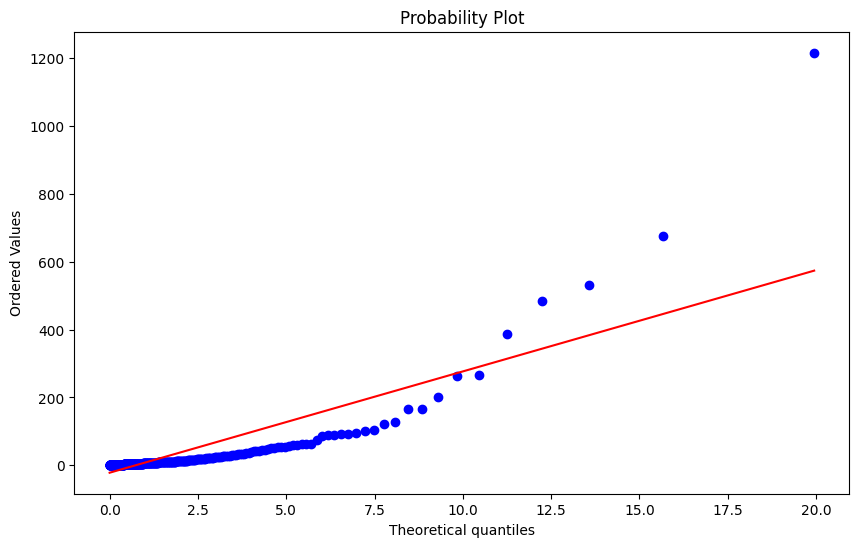

In [ ]:
# weibull
w = stats.weibull_min.fit(num)
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(num, dist=stats.weibull_min, sparams=(w[0], ), plot=ax)

# Daily Implied volatility

$$
IV = 2 \cdot FeeRate \cdot \sqrt{\frac{\text{Volume}}{\text{Liquidity}}}
$$

https://panoptic.xyz/research/comparing-uniswap-deribit-implied-volatilities

In [ ]:
FEE_RATE = 0.003
TICK_BASE = 1.0001

swap_data = data1_trade
swap_data_daily = data2_trade

In [ ]:
swap_data['time'] = data2_trade['time']

In [ ]:
swap_data

timestamp  blockNumber event       amount0       amount1  \
0         1630419316       227484  Swap  1.000000e+16 -1.800160e+07   
1         1630447626       228417  Swap -1.000000e+16  1.802073e+07   
2         1630453183       228739  Swap -4.937446e+15  1.000000e+07   
3         1630453308       228740  Swap -2.468040e+16  5.000000e+07   
4         1630453472       228753  Swap -3.606883e+16  7.500000e+07   
...              ...          ...   ...           ...           ...   
11813109  1732982395    279926782  Swap  1.555415e+17 -5.718012e+08   
11813110  1732982395    279926783  Swap  8.235291e+16 -3.027343e+08   
11813111  1732982396    279926785  Swap  2.340466e+17 -8.603268e+08   
11813112  1732982398    279926794  Swap  2.178866e+17 -8.008688e+08   
11813113  1732982398    279926794  Swap  8.289871e+17 -3.046578e+09   

             liquidity               sqrtPriceX96    tick                 time  
0         3.632972e+12  3171790482976860351510409 -202526  2021-08-31 22:15:16  
1         3.632972e+12  3564591523519471518150042 -200191  2021-09-01 06:07:06  
2         4.816712e+15  3564755927266088724290248 -200190  2021-09-01 07:39:43  
3         4.816712e+15  3565577945999174754991281 -200186  2021-09-01 07:41:48  
4         9.198078e+11  4705102282435095156608027 -194639  2021-09-01 07:44:32  
...                ...                        ...     ...                  ...  
11813109  3.860817e+17  4804877504220002857726133 -194219  2024-11-30 23:59:55  
11813110  3.860817e+17  4804815379861638111897504 -194220  2024-11-30 23:59:55  
11813111  3.860817e+17  4804638831454102077607992 -194220  2024-11-30 23:59:56  
11813112  4.159422e+17  4804483090705805953568020 -194221  2024-11-30 23:59:58  
11813113  4.159422e+17  4803902782231209583676537 -194223  2024-11-30 23:59:58  

[11813114 rows x 9 columns]

In [ ]:
swap_data['time'] = pd.to_datetime(swap_data['time'])
swap_data.set_index(['time'], inplace = True)

In [ ]:
swap_data

timestamp  blockNumber event       amount0  \
time                                                               
2021-08-31 22:15:16  1630419316       227484  Swap  1.000000e+16   
2021-09-01 06:07:06  1630447626       228417  Swap -1.000000e+16   
2021-09-01 07:39:43  1630453183       228739  Swap -4.937446e+15   
2021-09-01 07:41:48  1630453308       228740  Swap -2.468040e+16   
2021-09-01 07:44:32  1630453472       228753  Swap -3.606883e+16   
...                         ...          ...   ...           ...   
2024-11-30 23:59:55  1732982395    279926782  Swap  1.555415e+17   
2024-11-30 23:59:55  1732982395    279926783  Swap  8.235291e+16   
2024-11-30 23:59:56  1732982396    279926785  Swap  2.340466e+17   
2024-11-30 23:59:58  1732982398    279926794  Swap  2.178866e+17   
2024-11-30 23:59:58  1732982398    279926794  Swap  8.289871e+17   

                          amount1     liquidity               sqrtPriceX96  \
time                                                                         
2021-08-31 22:15:16 -1.800160e+07  3.632972e+12  3171790482976860351510409   
2021-09-01 06:07:06  1.802073e+07  3.632972e+12  3564591523519471518150042   
2021-09-01 07:39:43  1.000000e+07  4.816712e+15  3564755927266088724290248   
2021-09-01 07:41:48  5.000000e+07  4.816712e+15  3565577945999174754991281   
2021-09-01 07:44:32  7.500000e+07  9.198078e+11  4705102282435095156608027   
...                           ...           ...                        ...   
2024-11-30 23:59:55 -5.718012e+08  3.860817e+17  4804877504220002857726133   
2024-11-30 23:59:55 -3.027343e+08  3.860817e+17  4804815379861638111897504   
2024-11-30 23:59:56 -8.603268e+08  3.860817e+17  4804638831454102077607992   
2024-11-30 23:59:58 -8.008688e+08  4.159422e+17  4804483090705805953568020   
2024-11-30 23:59:58 -3.046578e+09  4.159422e+17  4803902782231209583676537   

                       tick  
time                         
2021-08-31 22:15:16 -202526  
2021-09-01 06:07:06 -200191  
2021-09-01 07:39:43 -200190  
2021-09-01 07:41:48 -200186  
2021-09-01 07:44:32 -194639  
...                     ...  
2024-11-30 23:59:55 -194219  
2024-11-30 23:59:55 -194220  
2024-11-30 23:59:56 -194220  
2024-11-30 23:59:58 -194221  
2024-11-30 23:59:58 -194223  

[11813114 rows x 8 columns]

In [ ]:
swap_data_daily_2023 = time_d('2023-01-01', swap_data, 365)

In [ ]:
swap_data_daily_2023

timestamp  blockNumber event       amount0  \
time                                                               
2023-01-01 00:00:08  1672502408     50039658  Swap -2.257248e+19   
2023-01-01 00:00:22  1672502422     50039691  Swap  8.316879e+13   
2023-01-01 00:00:41  1672502441     50039740  Swap -2.492569e+14   
2023-01-01 00:00:43  1672502443     50039744  Swap -9.970277e+14   
2023-01-01 00:00:44  1672502444     50039749  Swap  6.000000e+14   
...                         ...          ...   ...           ...   
2023-12-31 23:59:03  1704038343    165678922  Swap  1.504976e+17   
2023-12-31 23:59:13  1704038353    165678962  Swap -1.574800e+17   
2023-12-31 23:59:14  1704038354    165678966  Swap  6.430000e+18   
2023-12-31 23:59:24  1704038364    165679004  Swap -1.017668e+15   
2023-12-31 23:59:35  1704038375    165679051  Swap  2.612876e+17   

                          amount1     liquidity               sqrtPriceX96  \
time                                                                         
2023-01-01 00:00:08  2.716311e+10  4.685615e+18  2747940903370458613224846   
2023-01-01 00:00:22 -1.000000e+05  4.684203e+18  2747944755950245521972934   
2023-01-01 00:00:41  3.000000e+05  4.684203e+18  2747944761021879395082629   
2023-01-01 00:00:43  1.200000e+06  4.684203e+18  2747944781308414887521409   
2023-01-01 00:00:44 -7.214240e+05  4.684203e+18  2747944769106310862472687   
...                           ...           ...                        ...   
2023-12-31 23:59:03 -3.457235e+08  5.706423e+18  3798285655685741475525077   
2023-12-31 23:59:13  3.621257e+08  5.706423e+18  3798290680937312951461537   
2023-12-31 23:59:14 -1.477024e+10  5.706423e+18  3798085610443869426830691   
2023-12-31 23:59:24  2.339880e+06  5.706423e+18  3798085642914595318906789   
2023-12-31 23:59:35 -6.001655e+08  5.706423e+18  3798077310196937812990836   

                       tick  
time                         
2023-01-01 00:00:08 -205395  
2023-01-01 00:00:22 -205395  
2023-01-01 00:00:41 -205395  
2023-01-01 00:00:43 -205395  
2023-01-01 00:00:44 -205395  
...                     ...  
2023-12-31 23:59:03 -198921  
2023-12-31 23:59:13 -198921  
2023-12-31 23:59:14 -198922  
2023-12-31 23:59:24 -198922  
2023-12-31 23:59:35 -198922  

[4090805 rows x 8 columns]

In [ ]:
IV = pd.DataFrame()
IV['24H volume'] = swap_data_daily_2023['amount0'].abs().resample('1D').sum()
IV['liquidity'] = swap_data_daily_2023['liquidity'].resample('1D').last()

In [ ]:
IV['IV'] = 2 * FEE_RATE * np.sqrt(IV['24H volume'] / IV['liquidity'])

In [ ]:
IV

24H volume     liquidity        IV
time                                            
2023-01-01  6.307036e+21  4.736141e+18  0.218953
2023-01-02  1.117905e+22  4.230100e+18  0.308445
2023-01-03  1.036021e+22  4.707970e+18  0.281461
2023-01-04  1.809200e+22  2.918119e+18  0.472436
2023-01-05  1.539312e+22  3.262669e+18  0.412124
...                  ...           ...       ...
2023-12-27  3.295918e+22  4.861697e+18  0.494021
2023-12-28  4.827137e+22  5.805708e+18  0.547102
2023-12-29  4.059637e+22  5.696591e+18  0.506509
2023-12-30  2.799518e+22  6.565874e+18  0.391784
2023-12-31  7.102818e+21  5.706423e+18  0.211682

[365 rows x 3 columns]

# Daily Realized Volatility

Calculate Daily Realized Volatility from 15-minute tick data

In [ ]:
swap_data_daily_2023 = time_d('2023-01-01', swap_data_daily, 365)

In [ ]:
first_price = swap_data_daily_2023['tick'].resample('15min').first()
last_price = swap_data_daily_2023['tick'].resample('15min').last()
return_15min = (last_price - first_price)
return_15min = return_15min.dropna()

In [ ]:
return_15min

time
2023-01-01 00:00:00    -4.0
2023-01-01 00:15:00     0.0
2023-01-01 00:30:00    -3.0
2023-01-01 00:45:00     4.0
2023-01-01 01:00:00   -16.0
                       ... 
2023-12-31 21:45:00     1.0
2023-12-31 22:30:00     0.0
2023-12-31 23:00:00     1.0
2023-12-31 23:15:00     8.0
2023-12-31 23:45:00    11.0
Name: tick, Length: 34180, dtype: float64

In [ ]:
rv = return_15min.resample('1d').std()

In [ ]:
# Correctly converting from tick-based volatility to price-based volatility
rv = rv / 100

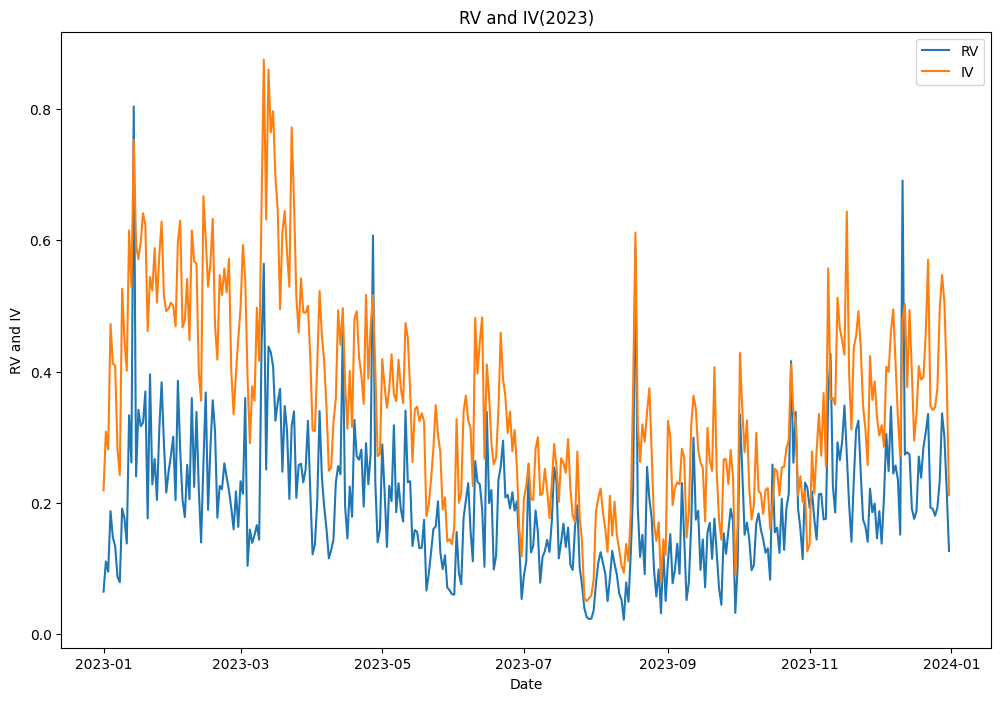

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(rv, label = 'RV')
plt.plot(IV['IV'], label = 'IV')
plt.title('RV and IV(2023)')
plt.xlabel('Date')
plt.ylabel('RV and IV')
plt.legend()

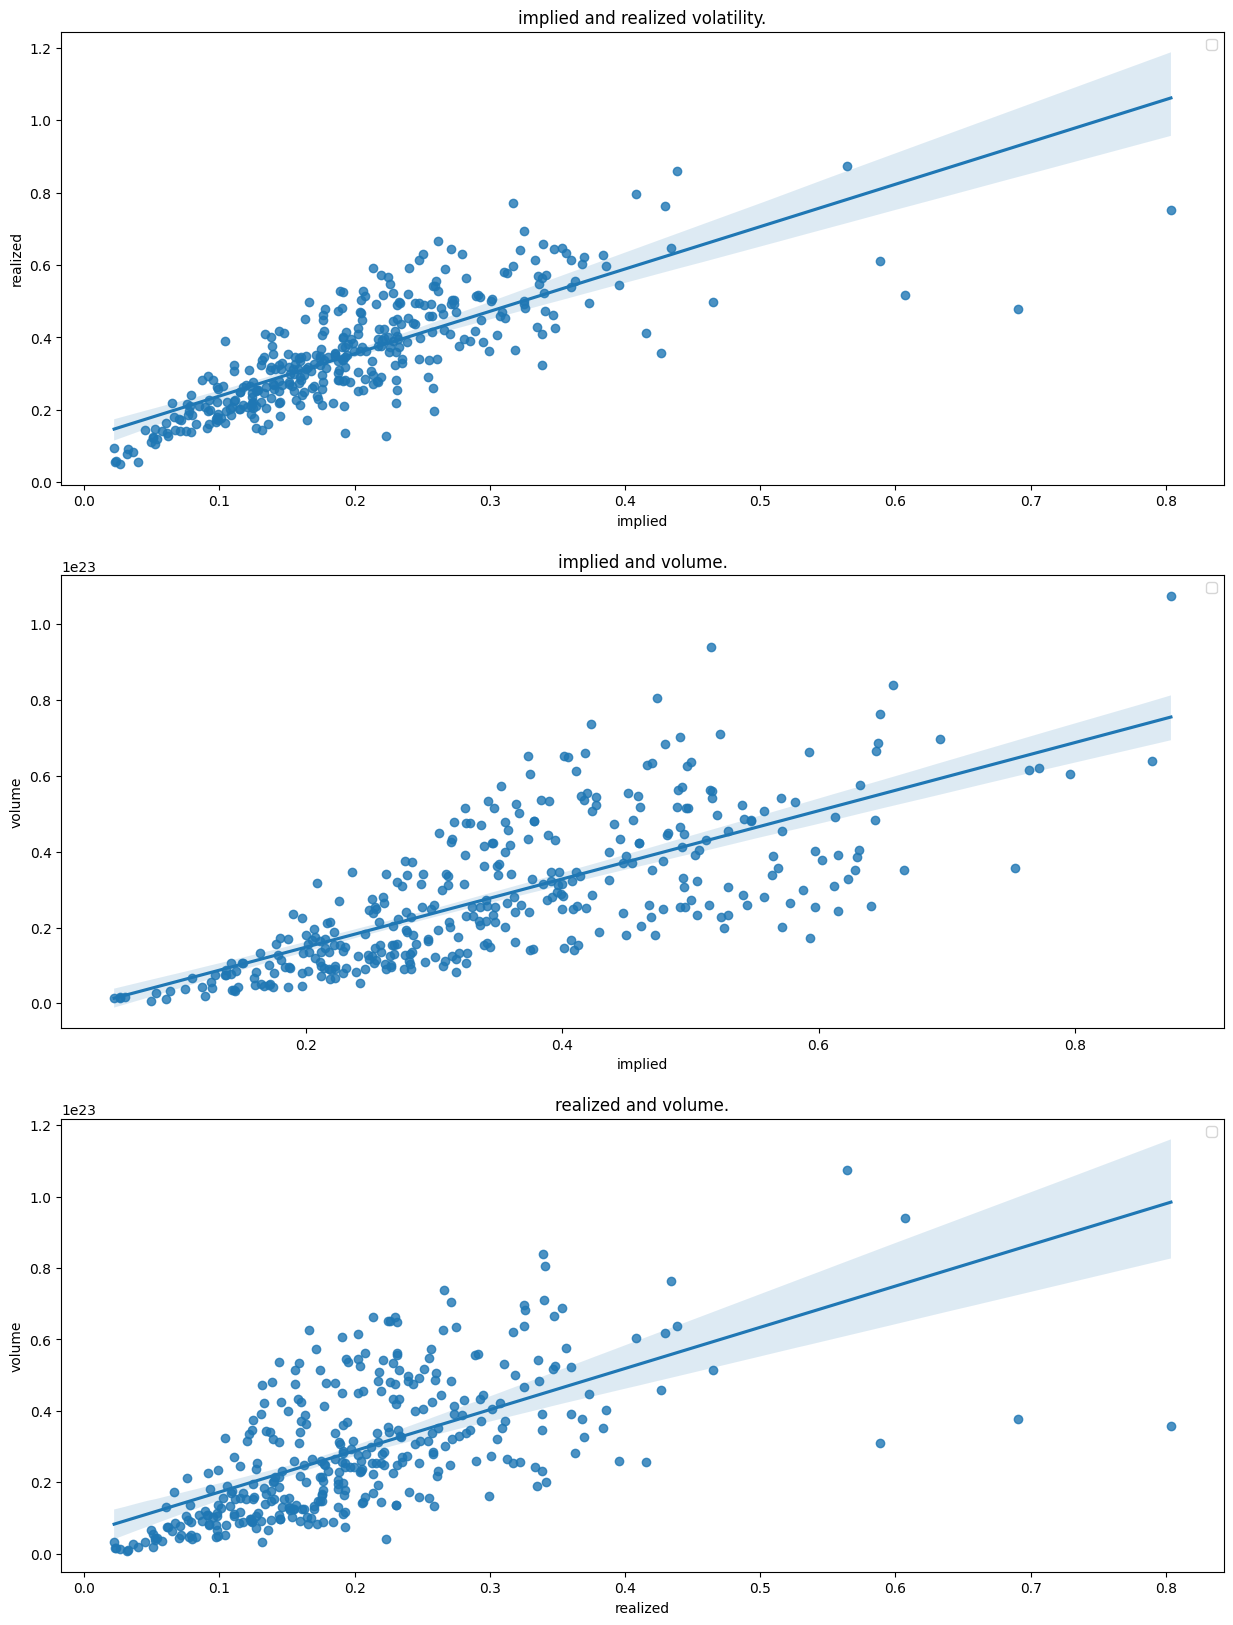

In [ ]:
plt.figure(figsize=(15, 20))
plt.subplot(311)
sns.regplot(x = rv,y = IV['IV'])
plt.title('implied and realized volatility.')
plt.xlabel('implied')
plt.ylabel('realized')
plt.legend()

plt.subplot(312)
sns.regplot( x= IV['IV'], y = IV['24H volume'])
plt.title('implied and volume.')
plt.xlabel('implied')
plt.ylabel('volume')
plt.legend()

plt.subplot(313)
sns.regplot(x= rv, y = IV['24H volume'])
plt.title('realized and volume.')
plt.xlabel('realized')
plt.ylabel('volume')
plt.legend()


In [ ]:
vv = pd.DataFrame()
vv['iv'] = rv
vv['rv'] = IV['IV']
vv['vol'] = IV['24H volume']

print(vv.corr())


           iv        rv       vol
iv   1.000000  0.794144  0.627150
rv   0.794144  1.000000  0.720669
vol  0.627150  0.720669  1.000000


# LVR
The P&L of the hedge position in units of USDT token at time $t$ is given by
$$Hedge = -( p_t  - p_0 ) *x_0$$

We assume that the hedge can be implemented by short selling the perpetual future and we treat the funding cost separately from the LP P&L. The value of the borrowed LP position at time *t* is given by

$$V borrowed = p_t x_t + y_t - [p_t - p_0] x_0$$

Thus the Pnl of the borrowed position at time $t$ is given by

$$
Pnl = (p_t x_t + y_t - [p_t - p_0] x_0)-(p_0 x_0 + y_0)
= (p_t x_t + y_t - p_t x_0 + y_0)
$$

In [ ]:
tickspace = 60  # The distance between ticks used for setting the price range (in tick units).
decimal_0 = 18  # The number of decimals for token 0 (WETH).
decimal_1 = 6   # The number of decimals for token 1 (USDC).

In [ ]:
def setrange(tickprice, tickspace, decimal_0, decimal_1):
  """
  Calculates the upper and lower price bounds for the liquidity position based on the current tick price and tick spacing.

  Args:
    tickprice: The current tick price.
    tickspace: The desired distance between ticks (in tick units) for the range.
    decimal_0: The number of decimals for token 0 (WETH).
    decimal_1: The number of decimals for token 1 (USDC).

  Returns:
    A tuple containing the upper and lower price bounds.
  """
  uppertick = tickprice + tickspace
  lowertick = tickprice - tickspace

  upperprice = 1.0001 ** uppertick * 10**(decimal_0 - decimal_1)
  lowerprice = 1.0001 ** lowertick * 10**(decimal_0 - decimal_1)

  return upperprice, lowerprice


In [ ]:
swap_data_daily_2023

timestamp  blockNumber event       amount0  \
time                                                               
2023-01-01 00:00:08  1672502408     50039658  Swap -2.257248e+19   
2023-01-01 00:00:22  1672502422     50039691  Swap  8.316879e+13   
2023-01-01 00:00:41  1672502441     50039740  Swap -2.492569e+14   
2023-01-01 00:00:43  1672502443     50039744  Swap -9.970277e+14   
2023-01-01 00:00:44  1672502444     50039749  Swap  6.000000e+14   
...                         ...          ...   ...           ...   
2023-12-31 23:59:03  1704038343    165678922  Swap  1.504976e+17   
2023-12-31 23:59:13  1704038353    165678962  Swap -1.574800e+17   
2023-12-31 23:59:14  1704038354    165678966  Swap  6.430000e+18   
2023-12-31 23:59:24  1704038364    165679004  Swap -1.017668e+15   
2023-12-31 23:59:35  1704038375    165679051  Swap  2.612876e+17   

                          amount1     liquidity               sqrtPriceX96  \
time                                                                         
2023-01-01 00:00:08  2.716311e+10  4.685615e+18  2747940903370458613224846   
2023-01-01 00:00:22 -1.000000e+05  4.684203e+18  2747944755950245521972934   
2023-01-01 00:00:41  3.000000e+05  4.684203e+18  2747944761021879395082629   
2023-01-01 00:00:43  1.200000e+06  4.684203e+18  2747944781308414887521409   
2023-01-01 00:00:44 -7.214240e+05  4.684203e+18  2747944769106310862472687   
...                           ...           ...                        ...   
2023-12-31 23:59:03 -3.457235e+08  5.706423e+18  3798285655685741475525077   
2023-12-31 23:59:13  3.621257e+08  5.706423e+18  3798290680937312951461537   
2023-12-31 23:59:14 -1.477024e+10  5.706423e+18  3798085610443869426830691   
2023-12-31 23:59:24  2.339880e+06  5.706423e+18  3798085642914595318906789   
2023-12-31 23:59:35 -6.001655e+08  5.706423e+18  3798077310196937812990836   

                       tick  
time                         
2023-01-01 00:00:08 -205395  
2023-01-01 00:00:22 -205395  
2023-01-01 00:00:41 -205395  
2023-01-01 00:00:43 -205395  
2023-01-01 00:00:44 -205395  
...                     ...  
2023-12-31 23:59:03 -198921  
2023-12-31 23:59:13 -198921  
2023-12-31 23:59:14 -198922  
2023-12-31 23:59:24 -198922  
2023-12-31 23:59:35 -198922  

[4090805 rows x 8 columns]

In [ ]:
def Amount_CAL_50_50(P_entry, initial_token_value):
    """
    Calculates the amount of each token (WETH and USDC) to deposit for a 50/50 initial allocation, given the entry price and initial value.

    Args:
      P_entry: The entry price of WETH/USDC (amount of USDC per WETH).
      initial_token_value: The total initial value to deposit (in USDC).

    Returns:
      A tuple containing the amount of token 0 (WETH) and token 1 (USDC).
    """
    token0_amount = initial_token_value // (2 * P_entry)  # Integer division to get the amount of WETH
    token1_amount = initial_token_value -  token0_amount * P_entry # Remaining value is allocated to USDC

    return token0_amount, token1_amount

In [ ]:
def IL_CAL(P_entry, P_exit, P_upper, P_lower, initial_token_value):
    """
    Calculates LP and the remaining amounts of each token when exiting a liquidity position.

    Args:
      P_entry: The entry price of WETH/USDC.
      P_exit: The exit price of WETH/USDC.
      P_upper: The upper price bound of the liquidity range.
      P_lower: The lower price bound of the liquidity range.
      initial_token_value: The initial total value deposited (in USDC).

    Returns:
      A tuple containing:
        - The remaining amount of token 0 (WETH).
        - The remaining amount of token 1 (USDC).
        - The total value of the position if held without providing liquidity (holder_value).
        - The total value of the LP position at exit (lp_value).
    """

    token0_amount, token1_amount = Amount_CAL_50_50(P_entry, initial_token_value)

    # Calculate the liquidity constant (L) based on the entry price and bounds.
    if P_entry < P_lower:
        L = token0_amount / (1/P_lower**(1/2)-1/P_upper**(1/2))
    elif P_entry > P_upper:
        L = token1_amount / (P_upper**(1/2)-P_lower**(1/2))
    else:
        L = token1_amount / (P_entry ** (1 / 2) - P_lower ** (1 / 2))

    # Calculate the virtual amounts of tokens that would be held at the range boundaries.
    token0_virtual_amount = L / P_upper**(1/2)
    token1_virtual_amount = L * P_lower**(1/2)

    # Calculate the remaining amounts of each token based on the exit price.
    if P_lower <= P_exit <= P_upper:
        token0_remain_amount = L / P_exit ** (1 / 2) - token0_virtual_amount
        token1_remain_amount = L * P_exit ** (1 / 2) - token1_virtual_amount
    elif P_exit < P_lower:
        token0_remain_amount = L/P_lower**(1/2) - token0_virtual_amount
        token1_remain_amount = L*P_lower**(1/2) - token1_virtual_amount
    elif P_exit > P_upper:
        token0_remain_amount = L/P_upper**(1/2) - token0_virtual_amount
        token1_remain_amount = L*P_upper**(1/2) - token1_virtual_amount

    # Calculate the value of the position if simply held vs. providing liquidity.
    holder_value = token1_amount + token0_amount * P_exit
    lp_value = token1_remain_amount + token0_remain_amount * P_exit

    return token0_remain_amount, token1_remain_amount, holder_value, lp_value

In [ ]:
def calculate_lvr(data, timescale, tickspace, decimal_0, decimal_1, initial_token_value):

  """
  Calculates the LVR, which is the P&L of the delta-hedged LP position, over a given timescale.

  Args:
      data: The input DataFrame containing Uniswap V3 swap data (must have a 'tick' column).
      timescale: The resampling timescale (e.g., '1d' for daily).
      tickspace: The tick spacing for setting the price range.
      decimal_0: The number of decimals for token 0.
      decimal_1: The number of decimals for token 1.
      initial_token_value: The initial value to deposit (in USDC).

  Returns:
      A DataFrame with the following columns:
          - upperprice: The upper price bound for each period.
          - lowerprice: The lower price bound for each period.
          - closetick: The closing tick for each period.
          - closeprice: The closing price (USDC per WETH) for each period.
          - lp_value: The value of the LP position at the end of each period.
          - hedge_value: The value of the short hedge position at the end of each period.
          - hedged_pnl(LVR): The P&L of the hedged position (LVR) for each period.
    """



  tickpriceopen = data['tick'].resample(timescale).first()
  tickpriceclose = data['tick'].resample(timescale).last()

  upperprice, lowerprice = setrange(tickpriceclose, tickspace, decimal_0, decimal_1)

  df = pd.DataFrame()
  df['upperprice'] = upperprice
  df['lowerprice'] = lowerprice
  df['closetick'] = tickpriceclose
  df['closeprice'] = 1.0001 ** tickpriceclose * 10**(decimal_0 - decimal_1)

  # print(df)

  result_df = df
  result_df["lp_value"] = None
  result_df["hedge_value"] = None
  result_df["hedged_pnl(LVR)"] = None
  result_df["lp_value"].iloc[0] = 0
  result_df["hedge_value"].iloc[0] = 0
  result_df["hedged_pnl(LVR)"].iloc[0] = 0


  init = initial_token_value
  for t in range(result_df.shape[0]-1):


      p_upper = result_df["upperprice"].iloc[t]
      p_lower = result_df["lowerprice"].iloc[t]


      p_entry = result_df["closeprice"].iloc[t]
      p_exit = result_df["closeprice"].iloc[t+1]

      init_token0_amount, init_token1_amount = Amount_CAL_50_50(p_entry,initial_token_value=init)
      exit_token0_amount, exit_token1_amount, holder_value, lp_value = IL_CAL(p_entry, p_exit, p_upper, p_lower, init)


      result_df["lp_value"].iloc[t+1] = lp_value
      # Hedge value: Change in price * initial amount of token 0 (short position)
      result_df["hedge_value"].iloc[t+1] = -init_token0_amount*(p_exit-p_entry)
      # Hedged P&L (LVR): LP Value - Value if held (initial amounts at exit price)
      result_df["hedged_pnl(LVR)"].iloc[t+1] = lp_value - init_token0_amount*p_exit - init_token1_amount
  return result_df

In [ ]:
init = 1000000
result_1d = calculate_lvr(swap_data_daily_2023, '1d', tickspace, decimal_0, decimal_1, initial_token_value=init)
result_8h = calculate_lvr(swap_data_daily_2023, '8h', tickspace, decimal_0, decimal_1, initial_token_value=init)
result_6h = calculate_lvr(swap_data_daily_2023, '6h', tickspace, decimal_0, decimal_1, initial_token_value=init)

串流輸出內容已截斷至最後 5000 行。
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  result_df["hedged_pnl(LVR)"].iloc[t+1] = lp_value - init_token0_amount*p_exit - init_token1_amount
<ipython-input-127-bb89965c0195>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["hedged_pnl(LVR)"].iloc[t+1] = lp_value - init_token0_amount*p_exit - init_token1_amount
<ipython-input-127-bb89965c0195>:40: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the inte

Text(0, 0.5, 'LVR')

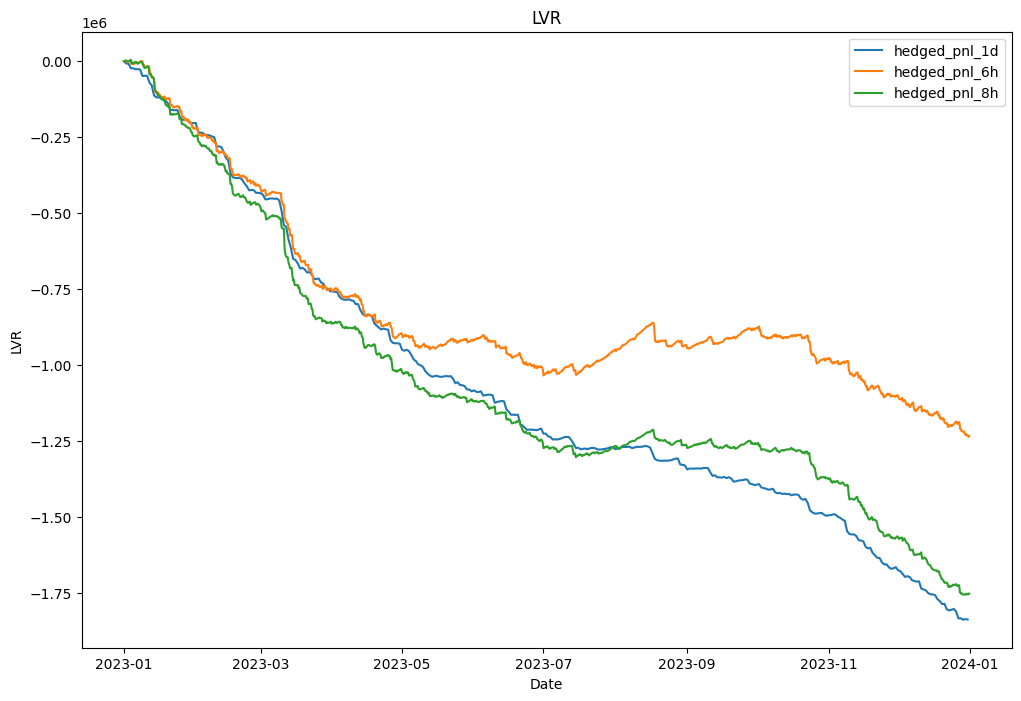

In [ ]:
plt.figure(figsize=(12, 8))
uu = result_6h['hedged_pnl(LVR)'].cumsum()
gg = result_8h['hedged_pnl(LVR)'].cumsum()
kk = result_1d['hedged_pnl(LVR)'].cumsum()

plt.plot(kk, label='hedged_pnl_1d')
plt.plot(uu, label='hedged_pnl_6h')
plt.plot(gg, label='hedged_pnl_8h')
plt.legend()
plt.title('LVR')
plt.xlabel('Date')
plt.ylabel('LVR')

# Mispricing

In [ ]:
c= pd.read_csv("CEX.csv")

time               Close
2    2023-01-01  1199.8468017578125
3    2023-01-02  1213.8221435546875
4    2023-01-03  1214.2357177734375
5    2023-01-04  1256.3145751953125
6    2023-01-05  1250.2403564453125
..          ...                 ...
726  2024-12-25     3483.1240234375
727  2024-12-26   3327.092529296875
728  2024-12-27    3321.92626953125
729  2024-12-28   3396.977783203125
730  2024-12-29    3348.80908203125

[729 rows x 2 columns]

In [ ]:
c

Date               Close                High                 Low  \
0        Ticker            WETH-USD            WETH-USD            WETH-USD   
1          Date                 NaN                 NaN                 NaN   
2    2023-01-01  1199.8468017578125  1202.9520263671875  1191.1407470703125   
3    2023-01-02  1213.8221435546875   1219.798583984375  1193.6947021484375   
4    2023-01-03  1214.2357177734375      1218.974609375   1205.787841796875   
..          ...                 ...                 ...                 ...   
726  2024-12-25     3483.1240234375   3510.953857421875   3458.400146484375   
727  2024-12-26   3327.092529296875   3490.141357421875     3318.9912109375   
728  2024-12-27    3321.92626953125   3411.638916015625   3312.864990234375   
729  2024-12-28   3396.977783203125     3399.7294921875    3321.92626953125   
730  2024-12-29    3348.80908203125   3399.608154296875    3338.04150390625   

                   Open      Volume  
0              WETH-USD    WETH-USD  
1                   NaN         NaN  
2    1195.7911376953125   266383514  
3    1199.8468017578125   374799583  
4      1213.62548828125   309902376  
..                  ...         ...  
726    3493.08544921875   818801497  
727    3483.12548828125   953965398  
728   3327.092529296875  1036343659  
729    3321.92626953125   779822929  
730     3397.0419921875   693145752  

[731 rows x 6 columns]

In [ ]:
c.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
# Drop the first row (index 0) which has NaN values
c = c.drop(index=0)
c

Date               Close                High                 Low  \
1          Date                 NaN                 NaN                 NaN   
2    2023-01-01  1199.8468017578125  1202.9520263671875  1191.1407470703125   
3    2023-01-02  1213.8221435546875   1219.798583984375  1193.6947021484375   
4    2023-01-03  1214.2357177734375      1218.974609375   1205.787841796875   
5    2023-01-04  1256.3145751953125  1264.8323974609375  1212.4149169921875   
..          ...                 ...                 ...                 ...   
726  2024-12-25     3483.1240234375   3510.953857421875   3458.400146484375   
727  2024-12-26   3327.092529296875   3490.141357421875     3318.9912109375   
728  2024-12-27    3321.92626953125   3411.638916015625   3312.864990234375   
729  2024-12-28   3396.977783203125     3399.7294921875    3321.92626953125   
730  2024-12-29    3348.80908203125   3399.608154296875    3338.04150390625   

                   Open      Volume  
1                   NaN         NaN  
2    1195.7911376953125   266383514  
3    1199.8468017578125   374799583  
4      1213.62548828125   309902376  
5    1214.2357177734375   736136492  
..                  ...         ...  
726    3493.08544921875   818801497  
727    3483.12548828125   953965398  
728   3327.092529296875  1036343659  
729    3321.92626953125   779822929  
730     3397.0419921875   693145752  

[730 rows x 6 columns]

In [ ]:
c = c[1:]

In [ ]:
c['Date'] = pd.to_datetime(c['Date'])

<ipython-input-54-c7b2b1168563>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['Date'] = pd.to_datetime(c['Date'])


In [ ]:
c['Close'] = pd.to_numeric(c['Close'])

<ipython-input-55-d66bc55c92d9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['Close'] = pd.to_numeric(c['Close'])


In [ ]:
cex = pd.DataFrame()
cex['time'] = c['Date']
cex['Close'] = c['Close']
cex

time        Close
2   2023-01-01  1199.846802
3   2023-01-02  1213.822144
4   2023-01-03  1214.235718
5   2023-01-04  1256.314575
6   2023-01-05  1250.240356
..         ...          ...
726 2024-12-25  3483.124023
727 2024-12-26  3327.092529
728 2024-12-27  3321.926270
729 2024-12-28  3396.977783
730 2024-12-29  3348.809082

[729 rows x 2 columns]

In [ ]:
cex['time'] = pd.to_datetime(cex['time'])
cex.set_index(['time'], inplace = True)

In [ ]:
cex_2023 = time_d('2023-01-01', cex, 365)

In [ ]:
cex_2023

Close
time                   
2023-01-01  1199.846802
2023-01-02  1213.822144
2023-01-03  1214.235718
2023-01-04  1256.314575
2023-01-05  1250.240356
...                 ...
2023-12-27  2377.934814
2023-12-28  2348.095459
2023-12-29  2298.085693
2023-12-30  2294.000000
2023-12-31  2280.468750

[365 rows x 1 columns]

In [ ]:
swap_data_daily['time'] = pd.to_datetime(swap_data_daily['time'])
swap_data_daily.set_index(['time'], inplace = True)

In [ ]:
swap_data_daily_2023_ = time_d('2023-01-01', swap_data_daily, 365)

In [ ]:
swap_data_daily_2023_ = swap_data_daily_2023_['price'].resample('1d').last()

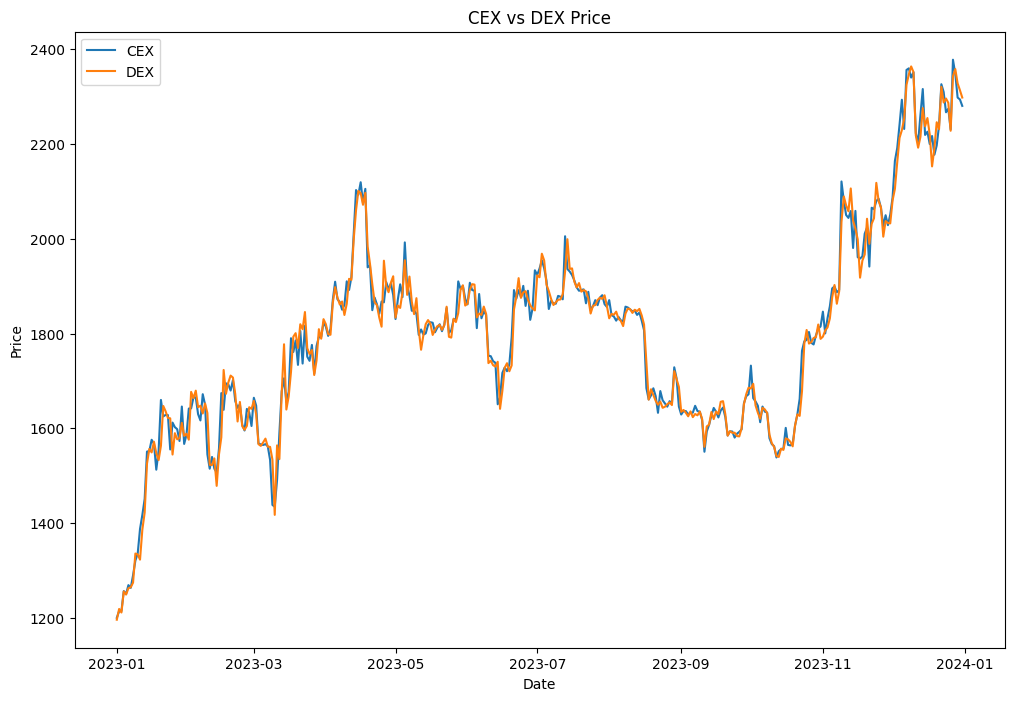

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(cex_2023['Close'], label ='CEX')
plt.plot(swap_data_daily_2023_, label = 'DEX')
plt.title('CEX vs DEX Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()


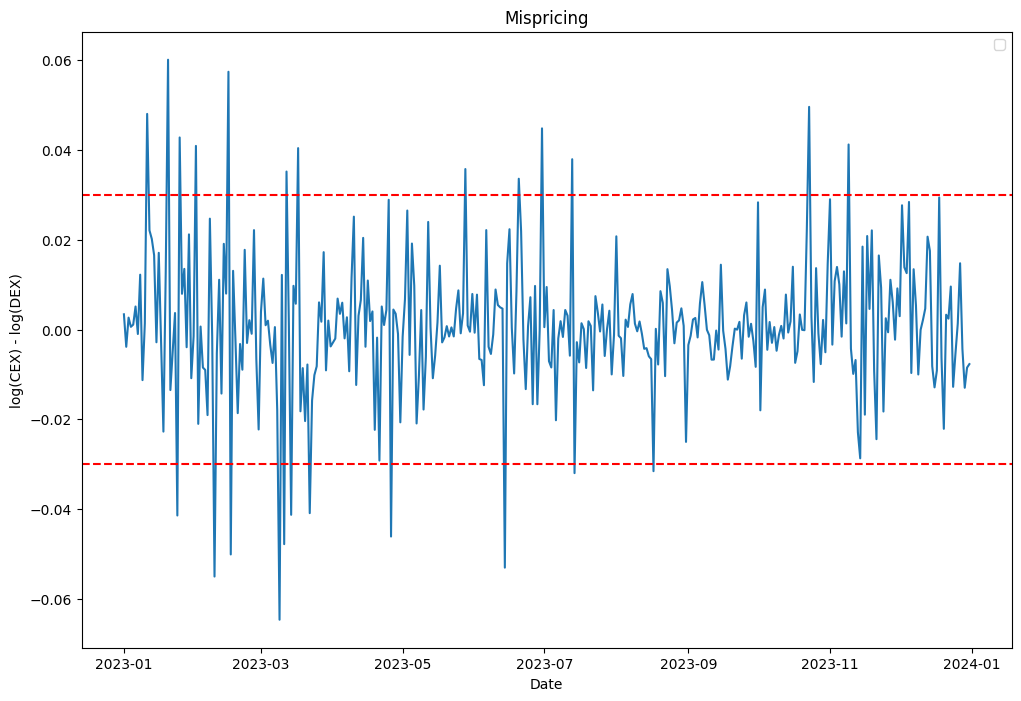

In [ ]:
plt.figure(figsize=(12, 8))
logcex = np.log(cex_2023['Close'])
logdex = np.log(swap_data_daily_2023_)
mis = logcex - logdex
plt.plot(mis)
plt.title('Mispricing')
plt.xlabel('Date')
plt.ylabel('log(CEX) - log(DEX)')
plt.legend()
gamma = 0.03
plt.axhline(y=gamma, color="r", linestyle="--", label="+γ")
plt.axhline(y=-gamma, color="r", linestyle="--", label="-γ")